In [77]:
import math
import matplotlib.pyplot as plt

In [85]:

# Lmax: Retransmit limit
# TXOP: in ms
# Imax: total slots in worst case
def analytical(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, mode='general'):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    # setting ocw_n [ocw_min, 1st_retry_ocw....]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
        
    Ri = [RA_RU for _ in range(0,Imax+1)]
    M  = [0 for _ in range(0,Imax+1)]
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    M_i_s_C = [0 for _ in range(0,Imax+1)] # total success packet

    
    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0

                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
                    
            M[i] += M_i[i][n]
            
        #/** statistics */  
        for n in range (1,Lmax+1) : # n=1;n<=Lmax;n++){
            if Ri[i] != 0: #avoid Ri=0
                if mode == 'general':
#                     print(M[i])
                    M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i])
#                     M_i_s[i][n] = M_i[i][n] * (1 - 1 / Ri[i]) ** (M[i] - 1)
                elif mode == 'power-ramping':
                    if M[i] != 0:
                        M_i_s[i][n] = M_i[i][n] * ( ((1-1/Ri[i]) ** (M[i]-1) ) + 3/4 * ((M[i]*M[i]-M[i]) / (2 * Ri[i]) * (1-1/Ri[i]) ** (M[i]-2) ) / M[i])
#                         M_i_s[i][n] = M_i[i][n] * math.exp(-M[i] / Ri[i]) + 3/4 * ((M[i]*M[i]-M[i]) / (2 * Ri[i]) * (1-1/Ri[i]) ** (M[i]-2) ) / M[i]
                    
            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_s_C[i] += M_i_s[i][n]


        #/** performance metric */  
        #/** success probability */
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
#         if i == Imax:
#             success_probability = success_packet / sta_amount

        
        counter_delay_slot += M_i_s_C[i] * i
    
#         if i == Imax:
#             access_delay = (TXOP * counter_delay_slot)
#             # 分群的access delay應該要是 (所有群成功的STA*上成功的slot)/所有群成功的STA數
    
    success_probability = success_packet / sta_amount
        
#     success_sta_cnt=0
#     for i in range(len(M_i_s_C)):
#         success_sta_cnt += M_i_s_C[i]
#     print(cnt, sta_amount)
    access_delay = (TXOP * counter_delay_slot) / success_packet
    
#     Throughput 
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    # sta*success_probability 來算 grouping的Ds
#     print(Imax,success_probability,access_delay,through_put)

    
    return Imax,success_probability,access_delay, utilization, through_put  # ,sta*success_probability
    
    


# Simulation vs Analytical

In [69]:
# Analytical
R = [9,18,37,74]
Lmax = 5
sta_max = 200
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]

# for r in R:
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31)
        ps_list[idx][sta-1] = Ps
        da_list[idx][sta-1] = Da
        u_list[idx][sta-1] = U


In [70]:
# Simulation

m_list_simu = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]

ps_list_simu_9 = [0.9997999999999999, 0.9902000000000015, 0.9014666666666623, 0.7052749999999992, 0.5154800000000009, 0.3786166666666661, 0.2772285714285717, 0.2132875000000002, 0.16926666666666687, 0.13838999999999999, 0.11561818181818188, 0.09967499999999979, 0.0879846153846159, 0.07848571428571441, 0.06906000000000011, 0.062231249999999926, 0.057423529411765165, 0.05272777777777791, 0.04893684210526309, 0.04517999999999991]
da_list_simu_9 = [13.760428800000055, 23.858954273310175, 32.8630578381784, 39.32447006314153, 43.7665458696133, 47.70350564560508, 50.959955712286934, 54.051942390819065, 56.80389733341128, 59.134793667001034, 61.35972823368223, 63.011054520729665, 64.31006401401686, 65.53324285159015, 66.59142136784328, 67.46475207246483, 68.06890644741473, 68.71466950185318, 69.18647978408733, 69.77077778802835]
t_list_simu_9 = [0.6665333333333303, 1.3202666666666623, 1.8029333333333246, 1.8807333333333323, 1.7182666666666628, 1.5144666666666644, 1.293733333333337, 1.1375333333333366, 1.015600000000001, 0.9225999999999985, 0.8478666666666648, 0.7973999999999983, 0.7625333333333341, 0.7325333333333327, 0.6906000000000018, 0.6638000000000016, 0.6508000000000024, 0.6327333333333347, 0.6198666666666688, 0.602400000000002]
u_list_simu_9 = [0.07405925925926019, 0.14669629629629777, 0.20032592592592585, 0.20897037037037053, 0.19091851851851852, 0.1682740740740738, 0.1437481481481479, 0.1263925925925929, 0.11284444444444461, 0.1025111111111111, 0.09420740740740743, 0.0886000000000001, 0.08472592592592597, 0.08139259259259278, 0.07673333333333342, 0.07375555555555573, 0.07231111111111126, 0.07030370370370381, 0.06887407407407412, 0.0669333333333334]

ps_list_simu_18 = [1.0, 0.9994000000000001, 0.986933333333332, 0.9153500000000023, 0.7527600000000002, 0.5670166666666665, 0.41971428571428365, 0.3104374999999994, 0.2349444444444442, 0.1842399999999998, 0.14676363636363637, 0.12054166666666655, 0.10135384615384664, 0.08603571428571431, 0.07586000000000014, 0.06701250000000006, 0.05968823529411814, 0.05437777777777794, 0.04904210526315793, 0.045219999999999934]
da_list_simu_18 = [8.69614170000004, 12.541120293859693, 17.518954552511683, 22.04008713411376, 25.284733615007582, 27.642955582845964, 29.52786611737373, 31.25986880608977, 32.86045096952514, 34.50439774916807, 36.037752805383455, 37.30717554371853, 38.365603779904404, 39.5528169117319, 40.39795374160477, 41.12845737761472, 41.709604140085254, 42.26204909716202, 42.7985242219769, 43.17184280250003]
t_list_simu_18 = [1.25, 2.4985, 3.701, 4.57675, 4.70475, 4.252625, 3.6725, 3.104375, 2.643125, 2.303, 2.018, 1.808125, 1.647, 1.505625, 1.422375, 1.34025, 1.268375, 1.2235, 1.16475, 1.1305]
u_list_simu_18 = [0.06944444444444328, 0.13880555555555324, 0.20561111111111288, 0.2542638888888892, 0.2613750000000002, 0.23625694444444434, 0.20402777777777778, 0.17246527777777768, 0.14684027777777772, 0.1279444444444446, 0.11211111111111141, 0.10045138888888894, 0.09149999999999972, 0.08364583333333313, 0.07902083333333315, 0.07445833333333331, 0.07046527777777765, 0.06797222222222218, 0.06470833333333324, 0.06280555555555555]

ps_list_simu_37 = [1.0, 1.0, 0.9997333333333333, 0.9993750000000003, 0.9936400000000014, 0.9630666666666636, 0.8733714285714272, 0.7269500000000015, 0.5662000000000005, 0.4279399999999999, 0.3165818181818189, 0.23275833333333332, 0.17060769230769307, 0.12736428571428574, 0.09323333333333357, 0.06943125000000004, 0.05214117647058868, 0.03921666666666693, 0.029110526315789444, 0.021999999999999967]
da_list_simu_37 = [6.9318387000000055, 8.43149625000004, 10.060079478571424, 11.897342021616561, 13.93035311254236, 15.939874096255403, 17.38710008869894, 18.19831483915023, 18.395875880272747, 18.3933201569513, 18.33784571779625, 18.160993744428357, 17.96132223755282, 17.727006761204876, 17.607619333859212, 17.549302416529958, 17.514595068816472, 17.413701462329364, 17.093778045929085, 16.909878453354988]
t_list_simu_37 = [2.0, 4.0, 5.998399999999999, 7.995000000000003, 9.93640000000002, 11.556800000000067, 12.22720000000002, 11.631200000000025, 10.191600000000006, 8.5588, 6.9647999999999985, 5.586199999999987, 4.4358, 3.566200000000002, 2.797, 2.2218000000000013, 1.7727999999999988, 1.4118000000000002, 1.1061999999999992, 0.8799999999999998]
u_list_simu_37 = [0.05405405405405456, 0.10810810810810911, 0.1621189189189182, 0.21608108108108304, 0.26855135135134767, 0.3123459459459453, 0.3304648648648653, 0.3143567567567564, 0.27544864864864876, 0.23131891891891873, 0.18823783783783796, 0.15097837837837844, 0.11988648648648655, 0.09638378378378346, 0.07559459459459454, 0.06004864864864894, 0.04791351351351356, 0.03815675675675672, 0.02989729729729737, 0.02378378378378386]

ps_list_simu_74 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999942857142857, 0.9994750000000002, 0.998755555555555, 0.9947500000000026, 0.9850545454545507, 0.9636083333333384, 0.927792307692297, 0.8702499999999999, 0.802246666666666, 0.7279937500000004, 0.6463117647058834, 0.5693388888888891, 0.49451052631578957, 0.43104999999999993]
da_list_simu_74 = [6.342981299999955, 7.035087300000035, 7.7733337000000144, 8.448373425000051, 9.256293720000016, 10.089808699999992, 10.982825504621841, 11.934976735880584, 12.963572132419694, 13.976710461206618, 15.03294053842881, 15.973086469713307, 16.82770849270516, 17.43948811344247, 17.87586546784776, 18.139953366963084, 18.297012176323875, 18.40746388290733, 18.373619490976324, 18.35358546940912]
t_list_simu_74 = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 13.9992, 15.991600000000004, 17.977600000000013, 19.894999999999996, 21.671199999999995, 23.1266, 24.122600000000002, 24.366999999999997, 24.067400000000006, 23.295800000000014, 21.974599999999988, 20.49619999999999, 18.791399999999985, 17.241999999999994]
u_list_simu_74 = [0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891783783783804, 0.2161027027027047, 0.24294054054054617, 0.2688513513513485, 0.292854054054051, 0.31252162162162245, 0.3259810810810811, 0.3292837837837837, 0.32523513513513475, 0.31480810810810794, 0.2969540540540535, 0.27697567567567566, 0.25393783783783797, 0.23299999999999968]


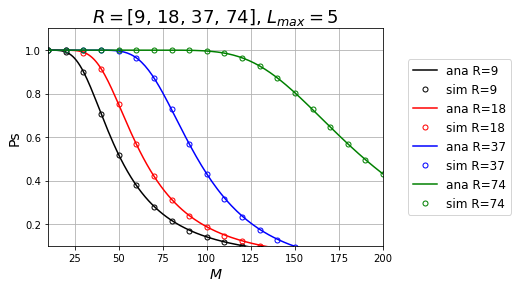

In [71]:
# Ps
plt.plot(m_list, ps_list[0], color='black', label='ana R=9')
plt.plot(m_list_simu, ps_list_simu_9, label='sim R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)

plt.plot(m_list, ps_list[1], color='red', label='ana R=18')
plt.plot(m_list_simu, ps_list_simu_18, label='sim R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

plt.plot(m_list, ps_list[2], color='blue', label='ana R=37')
plt.plot(m_list_simu, ps_list_simu_37, label='sim R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)

plt.plot(m_list, ps_list[3], color='green', label='ana R=74')
plt.plot(m_list_simu, ps_list_simu_74, label='sim R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) , fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5), fontsize = 12)
plt.axis([10,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

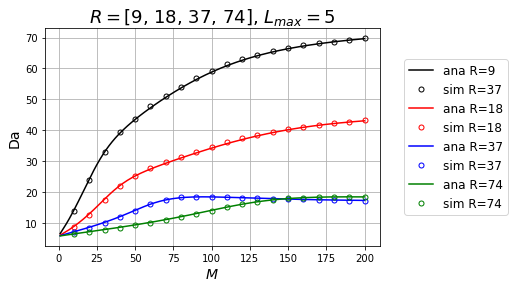

In [72]:
# Da
plt.plot(m_list, da_list[0], color='black', label='ana R=9')
plt.plot(m_list_simu, da_list_simu_9, label='sim R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)

plt.plot(m_list, da_list[1], color='red', label='ana R=18')
plt.plot(m_list_simu, da_list_simu_18, label='sim R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

plt.plot(m_list, da_list[2], color='blue', label='ana R=37')
plt.plot(m_list_simu, da_list_simu_37, label='sim R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)

plt.plot(m_list, da_list[3], color='green', label='ana R=74')
plt.plot(m_list_simu, da_list_simu_74, label='sim R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) , fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

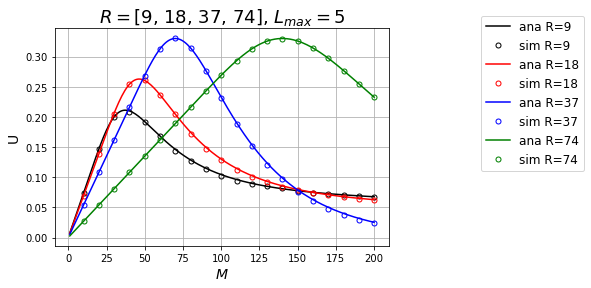

In [73]:
plt.plot(m_list, u_list[0], color='black', label='ana R=9')
plt.plot(m_list_simu, u_list_simu_9, label='sim R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)

plt.plot(m_list, u_list[1], color='red', label='ana R=18')
plt.plot(m_list_simu, u_list_simu_18, label='sim R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)

plt.plot(m_list, u_list[2], color='blue', label='ana R=37')
plt.plot(m_list_simu, u_list_simu_37, label='sim R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)

plt.plot(m_list, u_list[3], color='green', label='ana R=74')
plt.plot(m_list_simu, u_list_simu_74, label='sim R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) , fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.7), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

## Power-ramping

In [90]:
R = [9,18,37,74]
Lmax = 5
sta_max = 200
m_list = [i for i in range(1, sta_max+1)]
# ps_list = [0 for i in range(sta_max+1)]
ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_PR  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

# for r in R:
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31)
        ps_list[idx][sta-1] = Ps
        da_list[idx][sta-1] = Da
        u_list[idx][sta-1] = U
        

for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, mode='power-ramping')
        ps_list_PR[idx][sta-1] = Ps
        da_list_PR[idx][sta-1] = Da
        u_list_PR[idx][sta-1] = U

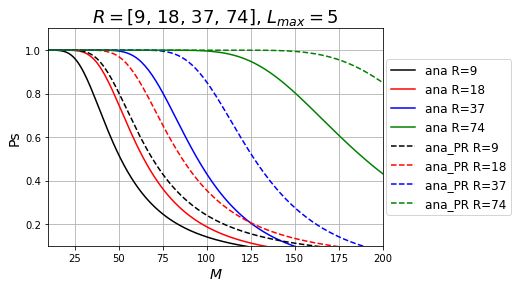

In [91]:
plt.plot(m_list, ps_list[0], color='black', label='ana R=9')
plt.plot(m_list, ps_list[1], color='red', label='ana R=18')
plt.plot(m_list, ps_list[2], color='blue', label='ana R=37')
plt.plot(m_list, ps_list[3], color='green', label='ana R=74')

plt.plot(m_list, ps_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, ps_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, ps_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, ps_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) , fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5), fontsize = 12)
plt.axis([10,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

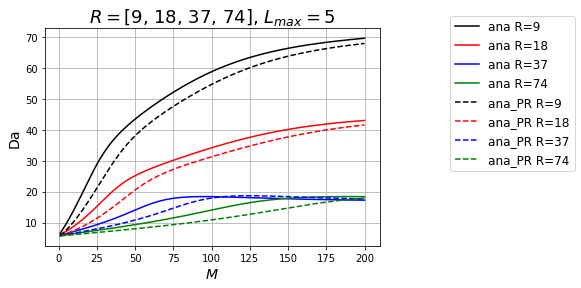

In [92]:
plt.plot(m_list, da_list[0], color='black', label='ana R=9')
plt.plot(m_list, da_list[1], color='red', label='ana R=18')
plt.plot(m_list, da_list[2], color='blue', label='ana R=37')
plt.plot(m_list, da_list[3], color='green', label='ana R=74')

plt.plot(m_list, da_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, da_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, da_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, da_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) , fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.7), fontsize = 12)
# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

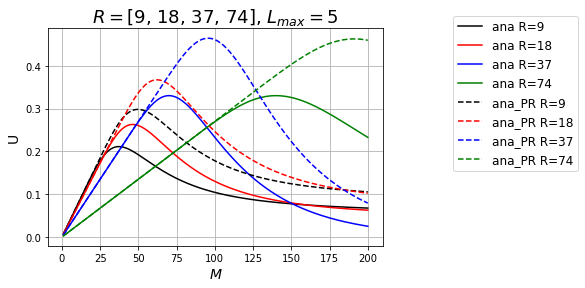

In [93]:
plt.plot(m_list, u_list[0], color='black', label='ana R=9')
plt.plot(m_list, u_list[1], color='red', label='ana R=18')
plt.plot(m_list, u_list[2], color='blue', label='ana R=37')
plt.plot(m_list, u_list[3], color='green', label='ana R=74')

plt.plot(m_list, u_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.plot(m_list, u_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.plot(m_list, u_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.plot(m_list, u_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) , fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.7), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()